<a href="https://colab.research.google.com/github/okanckaya/Pima-Indians-Diabetes-Prediction/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('gdrive/My Drive/VBO/Hafta 7/Ders Notları/diabetes.csv', error_bad_lines=False)

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

During pregnancy, some women have such high levels of blood glucose that their body is unable to produce enough insulin to absorb it all. This is known as gestational diabetes.

* https://www.nhs.uk/conditions/diabetes/

In [ ]:
glucose_labels = ['0_18', '19_23', '24_30', '31_40', '41_' + str(int(df["Age"].max()))]
df["Glucose_qcut"] = pd.qcut(df['Glucose'], 3, labels=glucose_labels)

**Oral Glucose Tolerance Test (OGTT)**

The OGTT is a two-hour test that checks your blood sugar levels before and two hours after you drink a special sweet drink. It tells the doctor how your body processes sugar.


Diabetes is diagnosed at 2 hour blood sugar of greater than or equal to 200 mg/dl


*Oral Glucose Tolerance Test (OGTT)*
*   less than 140 mg/dl -- Normal
*   140 mg/dl to 199 mg/dl -- Prediabetes
*   200 mg/dl or higher -- Diabetes

In [72]:
df.loc[(df['Glucose'] < 140), 'OGTT'] = 'Normal'
df.loc[((140 <= df['Glucose']) & (df['Glucose'] <= 199)), 'OGTT'] = 'Prediabetes'
df.loc[(df['Glucose'] > 199), 'OGTT'] = 'Diabetes'
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,OGTT
0,6,148,72,35,0,33.6,0.627,50,1,Prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Normal
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,Normal
764,2,122,70,27,0,36.8,0.340,27,0,Normal
765,5,121,72,23,112,26.2,0.245,30,0,Normal
766,1,126,60,0,0,30.1,0.349,47,1,Normal


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,OGTT_Normal,OGTT_Prediabetes,Outcome_0,Outcome_1
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,-0.131509,0.131509,-0.221898,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,-0.786815,0.786815,-0.466581,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,-0.140920,0.140920,-0.065068,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,-0.089647,0.089647,-0.074752,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,-0.284868,0.284868,-0.130548,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,-0.219281,0.219281,-0.292695,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,-0.109177,0.109177,-0.173844,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,-0.244703,0.244703,-0.238356,0.238356
OGTT_Normal,-0.131509,-0.786815,-0.140920,-0.089647,-0.284868,-0.219281,-0.109177,-0.244703,1.000000,-1.000000,0.414455,-0.414455
OGTT_Prediabetes,0.131509,0.786815,0.140920,0.089647,0.284868,0.219281,0.109177,0.244703,-1.000000,1.000000,-0.414455,0.414455


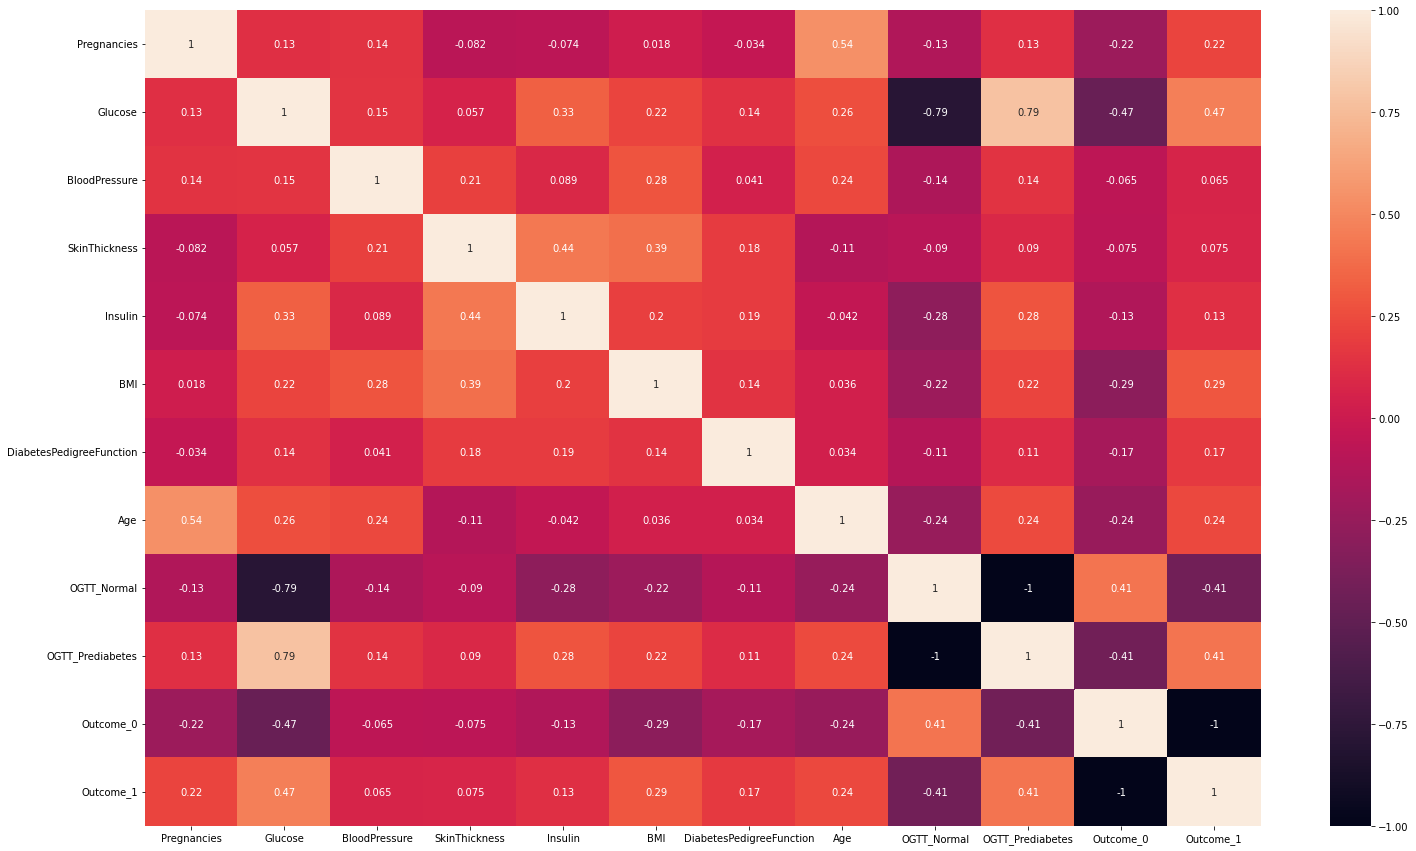

In [73]:
def show_correlations(df, show_chart = True):
    fig = plt.figure(figsize = (25,15))
    corr = df.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr

show_correlations(df_copy)

In [74]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [75]:
df_copy = df.copy()
df_copy = df_copy.iloc[:, [0,1,2,3,4,5,6,7,9,8]]
df_copy

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,OGTT,Outcome
0,6,148,72,35,0,33.6,0.627,50,Prediabetes,1
1,1,85,66,29,0,26.6,0.351,31,Normal,0
2,8,183,64,0,0,23.3,0.672,32,Prediabetes,1
3,1,89,66,23,94,28.1,0.167,21,Normal,0
4,0,137,40,35,168,43.1,2.288,33,Normal,1
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,Normal,0
764,2,122,70,27,0,36.8,0.340,27,Normal,0
765,5,121,72,23,112,26.2,0.245,30,Normal,0
766,1,126,60,0,0,30.1,0.349,47,Normal,1


In [76]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_copy)

Observations: 768
Variables: 10
cat_cols: 2
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [77]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [78]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [79]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [80]:
check_outlier(df_copy, num_cols)

True

In [81]:
print(check_outlier(df_copy, "Pregnancies"))
print(check_outlier(df_copy, "Glucose"))
print(check_outlier(df_copy, "BloodPressure"))
print(check_outlier(df_copy, "SkinThickness"))
print(check_outlier(df_copy, "Insulin"))
print(check_outlier(df_copy, "BMI"))
print(check_outlier(df_copy, "Age"))
print(check_outlier(df_copy, "Outcome"))

False
False
False
False
True
False
False
False


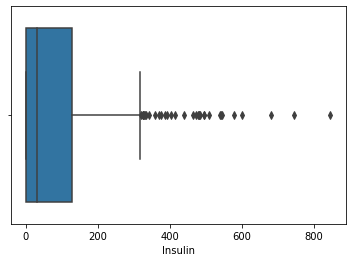

In [82]:
sns.boxplot(x=df_copy["Insulin"])
plt.show()

Ağaç temelli yöntemler kullanılacağı için outlierlara dokunulmadı.

In [83]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [84]:
df_copy = one_hot_encoder(df_copy, cat_cols, drop_first=True)

In [85]:
df_copy

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,OGTT_Prediabetes,Outcome_1
0,6,148,72,35,0,33.6,0.627,50,1,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,0,0
4,0,137,40,35,168,43.1,2.288,33,0,1
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0
764,2,122,70,27,0,36.8,0.340,27,0,0
765,5,121,72,23,112,26.2,0.245,30,0,0
766,1,126,60,0,0,30.1,0.349,47,0,1


In [86]:
# The distribution of the actual values and the predictions made by the algorithms is intended to be shown not only with numerical error metrics, but also with visual graphics:

def predVisualization(test_pred, y_test):
  x_ax = range(len(test_pred))
  figure(figsize=(30, 10), dpi=80)
  plt.scatter(x_ax, y_test, lw=6, color="blue", label="original")
  plt.scatter(x_ax, test_pred, lw=4, color="red", label="predicted_rtc")
  plt.legend()
  plt.style.use('default')
  plt.show()

In [87]:
######################## Without Outliers ########################
# Tüm parametreler
X = df_copy.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]].values
y = df_copy.iloc[:, 9].values

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

In [126]:
# Splitting dataset:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [127]:
def LogRes(X_train, y_train, X_test, y_test):
  lr = LogisticRegression()
  model = lr.fit(X_train, y_train)
  train_preds = lr.predict(X_train)
  test_preds = lr.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

  return accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test, roc_auc_score_train, roc_auc_score_test, precision_score_train, precision_score_test, recall_score_train, recall_score_test, 

accuracy_score_train:  419
accuracy_score_test:  171
f1_score_train:  0.650887573964497
f1_score_test:  0.625
roc_auc_score_train:  0.7352466012314821
roc_auc_score_test:  0.7131622516556292
precision_score_train:  0.7333333333333333
precision_score_test:  0.625
recall_score_train:  0.5851063829787234
recall_score_test:  0.625
confusion_matrix_train:  [[309  40]
 [ 78 110]]
confusion_matrix_test:  [[121  30]
 [ 30  50]]


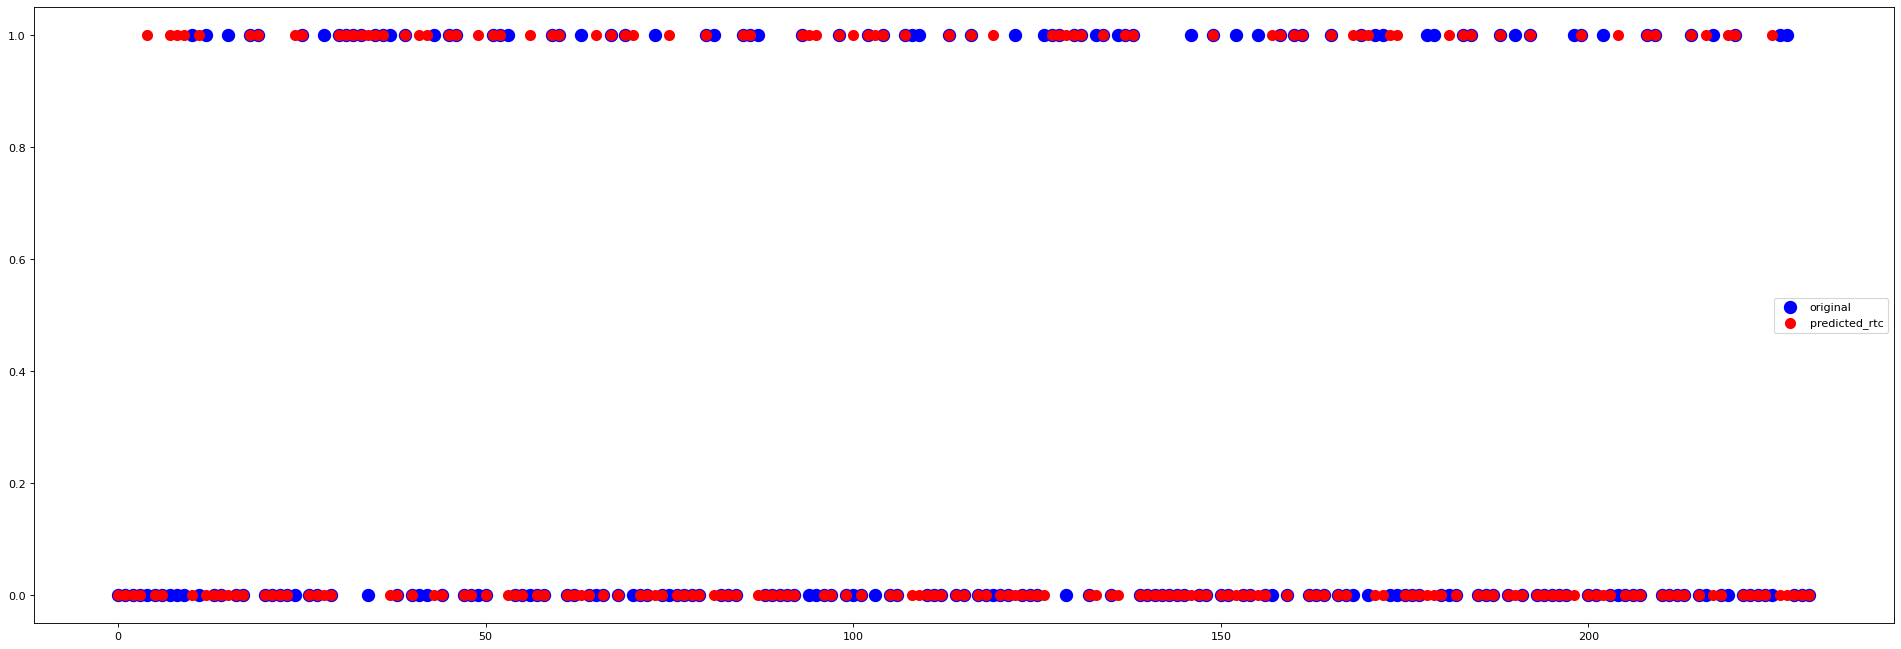

In [128]:
accuracy_score_train_lr, accuracy_score_test_lr, f1_score_train_lr, f1_score_test_lr, roc_auc_score_train_lr, roc_auc_score_test_lr, precision_score_train_lr, precision_score_test_lr, recall_score_train_lr, recall_score_test_lr,  = LogRes(X_train, y_train, X_test, y_test)

In [129]:
def XGB(X_train, y_train, X_test, y_test):
  xgb = XGBClassifier()
  model = xgb.fit(X_train, y_train)
  train_preds = xgb.predict(X_train)
  test_preds = xgb.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

  return accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test, roc_auc_score_train, roc_auc_score_test, precision_score_train, precision_score_test, recall_score_train, recall_score_test, 

accuracy_score_train:  493
accuracy_score_test:  173
f1_score_train:  0.8797814207650274
f1_score_test:  0.6588235294117647
roc_auc_score_train:  0.9038361885021032
roc_auc_score_test:  0.7374172185430463
precision_score_train:  0.9044943820224719
precision_score_test:  0.6222222222222222
recall_score_train:  0.8563829787234043
recall_score_test:  0.7
confusion_matrix_train:  [[332  17]
 [ 27 161]]
confusion_matrix_test:  [[117  34]
 [ 24  56]]


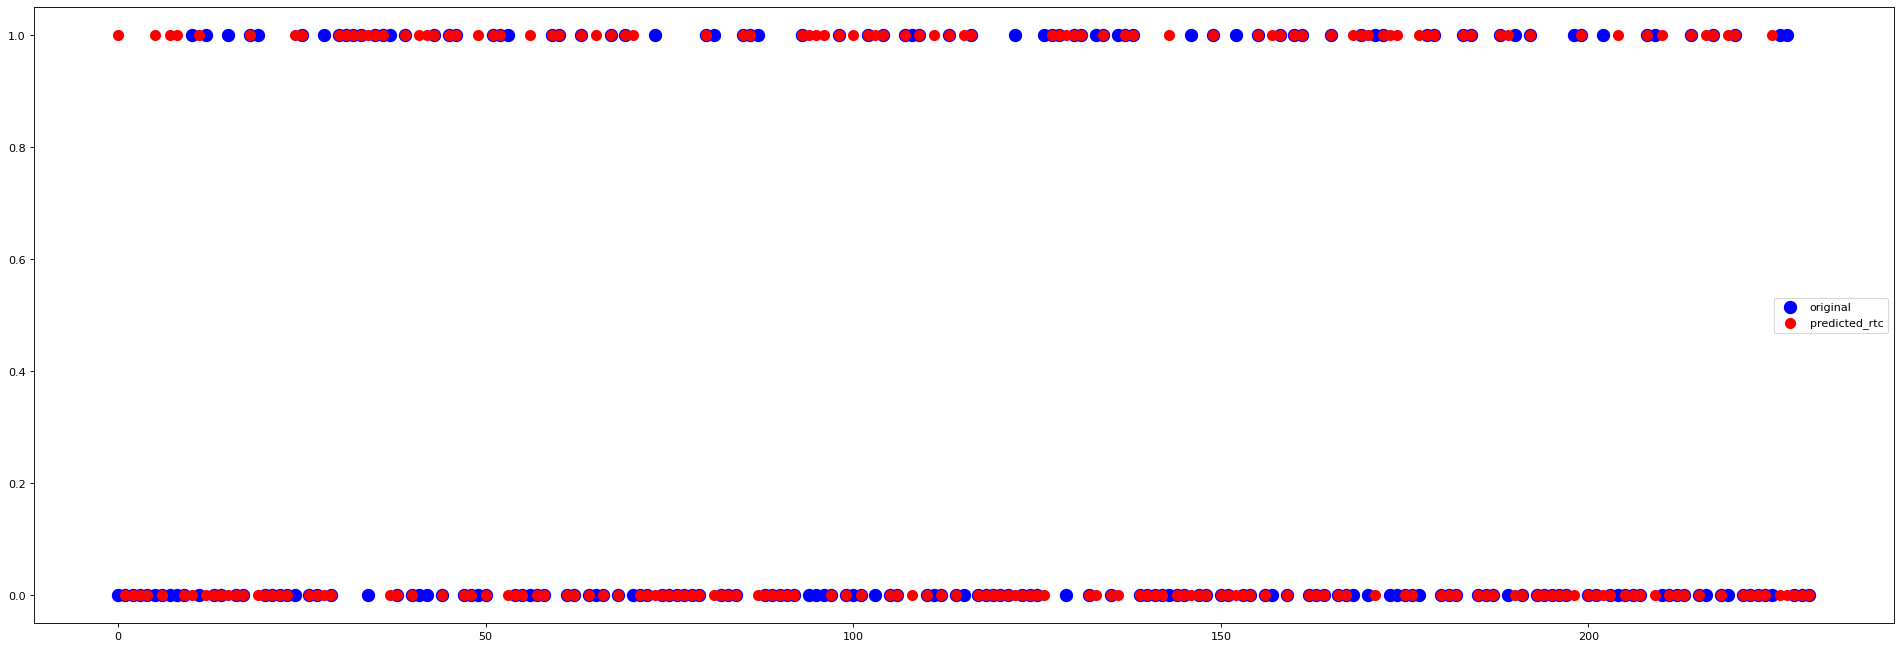

In [130]:
accuracy_score_train_xgb, accuracy_score_test_xgb, f1_score_train_xgb, f1_score_test_xgb, roc_auc_score_train_xgb, roc_auc_score_test_xgb, precision_score_train_xgb, precision_score_test_xgb, recall_score_train_xgb, recall_score_test_xgb = XGB(X_train, y_train, X_test, y_test)

In [131]:
def KNN(X_train, y_train, X_test, y_test):
  knn = KNeighborsClassifier()
  model = knn.fit(X_train, y_train)
  train_preds = knn.predict(X_train)
  test_preds = knn.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

  return accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test, roc_auc_score_train, roc_auc_score_test, precision_score_train, precision_score_test, recall_score_train, recall_score_test, 

accuracy_score_train:  440
accuracy_score_test:  161
f1_score_train:  0.7204610951008645
f1_score_test:  0.5454545454545455
roc_auc_score_train:  0.7837362067914405
roc_auc_score_test:  0.6565397350993378
precision_score_train:  0.7861635220125787
precision_score_test:  0.5675675675675675
recall_score_train:  0.6648936170212766
recall_score_test:  0.525
confusion_matrix_train:  [[315  34]
 [ 63 125]]
confusion_matrix_test:  [[119  32]
 [ 38  42]]


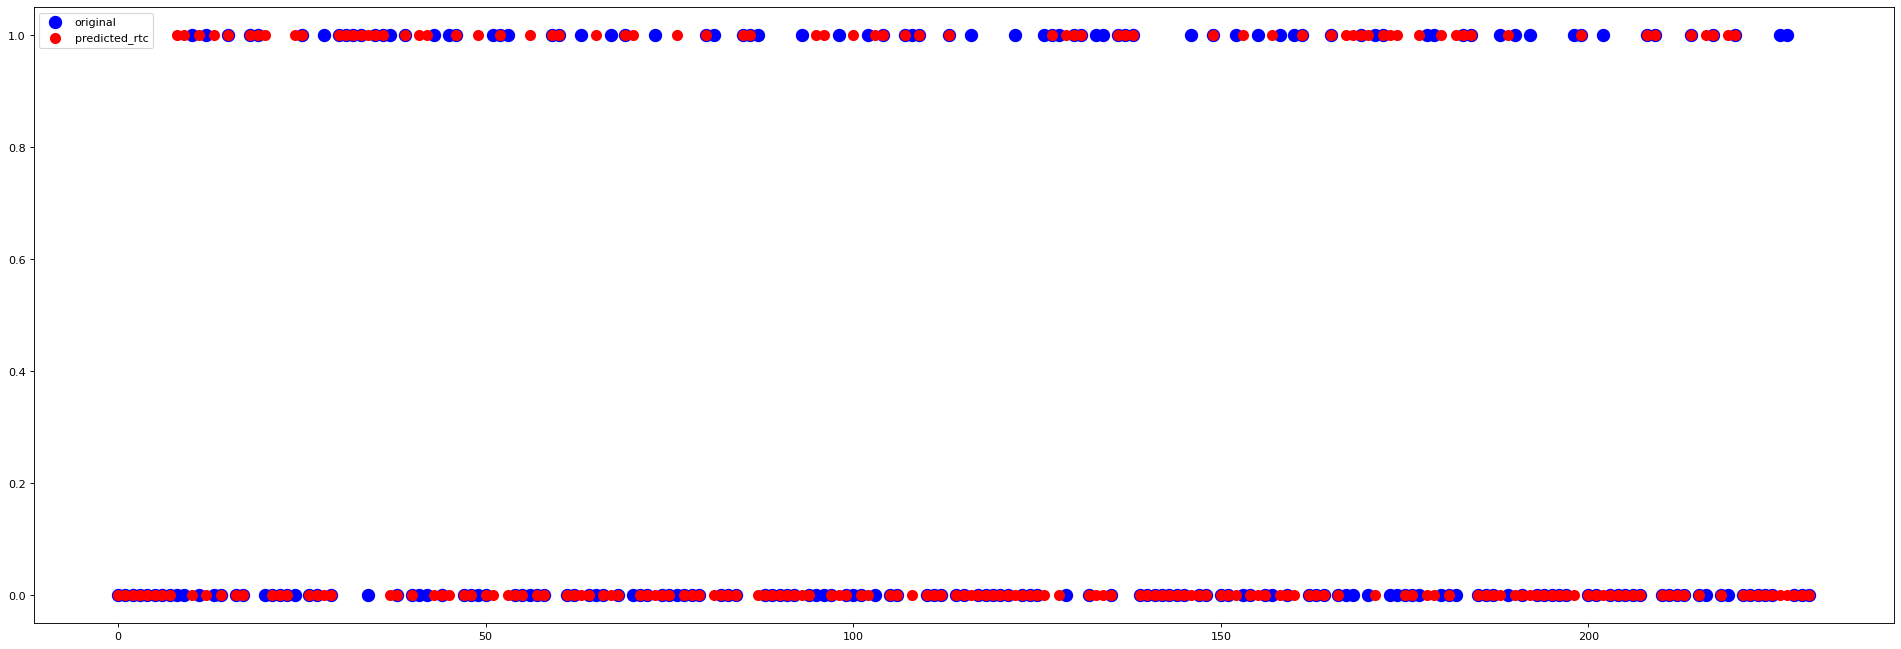

In [132]:
accuracy_score_train_knn, accuracy_score_test_knn, f1_score_train_knn, f1_score_test_knn, roc_auc_score_train_knn, roc_auc_score_test_knn, precision_score_train_knn, precision_score_test_knn, recall_score_train_knn, recall_score_test_knn = KNN(X_train, y_train, X_test, y_test)

In [133]:
def RFC(X_train, y_train, X_test, y_test):
  rfc = RandomForestClassifier(n_estimators=30)
  model = rfc.fit(X_train, y_train)
  train_preds = rfc.predict(X_train)
  test_preds = rfc.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

  return accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test, roc_auc_score_train, roc_auc_score_test, precision_score_train, precision_score_test, recall_score_train, recall_score_test, 

accuracy_score_train:  535
accuracy_score_test:  171
f1_score_train:  0.9946524064171123
f1_score_test:  0.6385542168674699
roc_auc_score_train:  0.9946808510638299
roc_auc_score_test:  0.7219784768211921
precision_score_train:  1.0
precision_score_test:  0.6162790697674418
recall_score_train:  0.9893617021276596
recall_score_test:  0.6625
confusion_matrix_train:  [[349   0]
 [  2 186]]
confusion_matrix_test:  [[118  33]
 [ 27  53]]


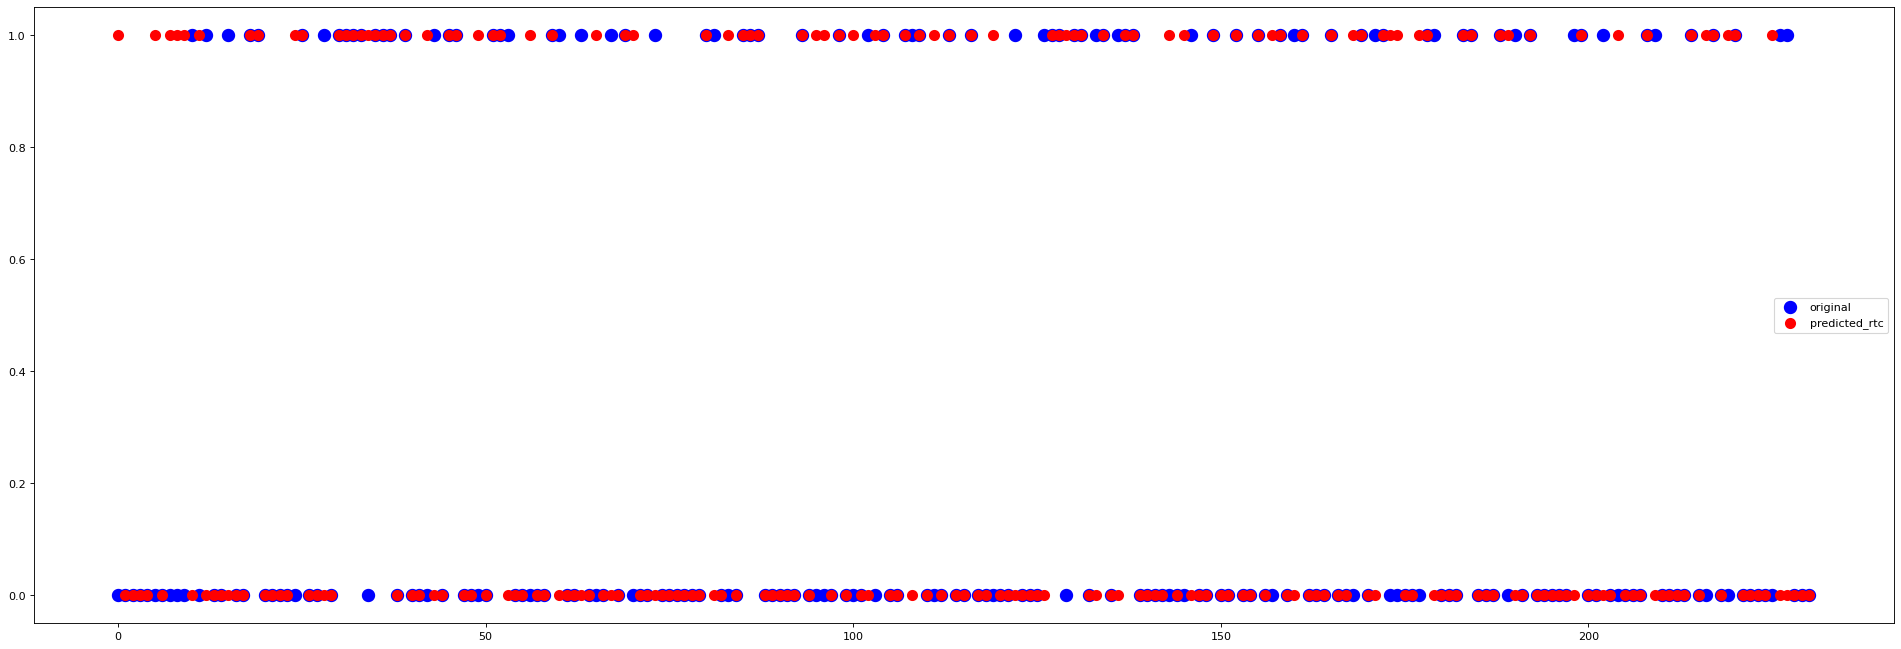

In [134]:
accuracy_score_train_rfc, accuracy_score_test_rfc, f1_score_train_rfc, f1_score_test_rfc, roc_auc_score_train_rfc, roc_auc_score_test_rfc, precision_score_train_rfc, precision_score_test_rfc, recall_score_train_rfc, recall_score_test_rfc = RFC(X_train, y_train, X_test, y_test)

In [135]:
def DTC(X_train, y_train, X_test, y_test):
  dtc = DecisionTreeClassifier()
  model = dtc.fit(X_train, y_train)
  train_preds = dtc.predict(X_train)
  test_preds = dtc.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

  return accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test, roc_auc_score_train, roc_auc_score_test, precision_score_train, precision_score_test, recall_score_train, recall_score_test, 

accuracy_score_train:  537
accuracy_score_test:  159
f1_score_train:  1.0
f1_score_test:  0.5862068965517241
roc_auc_score_train:  1.0
roc_auc_score_test:  0.676365894039735
precision_score_train:  1.0
precision_score_test:  0.5425531914893617
recall_score_train:  1.0
recall_score_test:  0.6375
confusion_matrix_train:  [[349   0]
 [  0 188]]
confusion_matrix_test:  [[108  43]
 [ 29  51]]


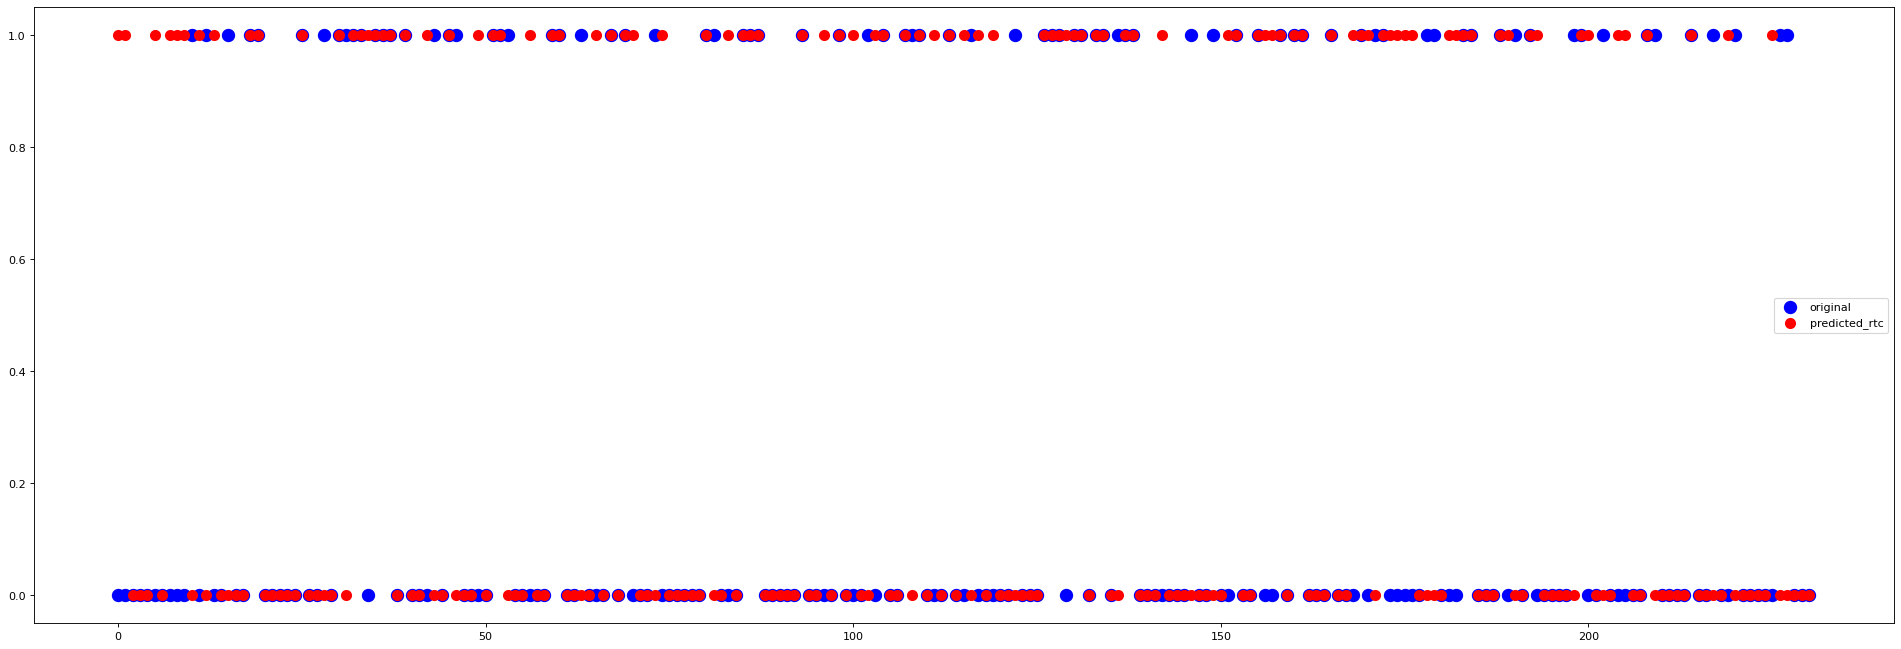

In [136]:
accuracy_score_train_dtc, accuracy_score_test_dtc, f1_score_train_dtc, f1_score_test_dtc, roc_auc_score_train_dtc, roc_auc_score_test_dtc, precision_score_train_dtc, precision_score_test_dtc, recall_score_train_dtc, recall_score_test_dtc = DTC(X_train, y_train, X_test, y_test)

In [137]:
tabulated_results = pd.DataFrame({
    'Metrics': ['Accuracy Score (Train)' , 'Accuracy Score (Test)' , 'F1 Score (Train)', 'F1 Score (Test)' ,
              'ROC AUC Score (Train)' , 'ROC AUC Score (Test)' , 'Precision Score (Train)', 'Precision Score (Test)',
              'Recall Score (Train)', 'Recall Score (Test)'],
    'Linear Regression': [accuracy_score_train_lr, accuracy_score_test_lr, f1_score_train_lr, f1_score_test_lr, 
                          roc_auc_score_train_lr, roc_auc_score_test_lr, precision_score_train_lr, precision_score_test_lr,
                          recall_score_train_lr, recall_score_test_lr],
    'XGB': [accuracy_score_train_xgb, accuracy_score_test_xgb, f1_score_train_xgb, f1_score_test_xgb,
            roc_auc_score_train_xgb, roc_auc_score_test_xgb, precision_score_train_xgb, precision_score_test_xgb,
            recall_score_train_xgb, recall_score_test_xgb],
    'KNN': [accuracy_score_train_knn, accuracy_score_test_knn, f1_score_train_knn, f1_score_test_knn,
            roc_auc_score_train_knn, roc_auc_score_test_knn, precision_score_train_knn, precision_score_test_knn,
            recall_score_train_knn, recall_score_test_knn],
    'RFC': [accuracy_score_train_rfc, accuracy_score_test_rfc, f1_score_train_rfc, f1_score_test_rfc,
            roc_auc_score_train_rfc, roc_auc_score_test_rfc, precision_score_train_rfc, precision_score_test_rfc,
            recall_score_train_rfc, recall_score_test_rfc],
    'DTC': [accuracy_score_train_dtc, accuracy_score_test_dtc, f1_score_train_dtc, f1_score_test_dtc,
            roc_auc_score_train_dtc, roc_auc_score_test_dtc, precision_score_train_dtc, precision_score_test_dtc,
            recall_score_train_dtc, recall_score_test_dtc],
            })

tabulated_results

,Metrics,Linear Regression,XGB,KNN,RFC,DTC
0,Accuracy Score (Train),419.000000,493.000000,440.000000,535.000000,537.000000
1,Accuracy Score (Test),171.000000,173.000000,161.000000,171.000000,159.000000
2,F1 Score (Train),0.650888,0.879781,0.720461,0.994652,1.000000
3,F1 Score (Test),0.625000,0.658824,0.545455,0.638554,0.586207
4,ROC AUC Score (Train),0.735247,0.903836,0.783736,0.994681,1.000000
5,ROC AUC Score (Test),0.713162,0.737417,0.656540,0.721978,0.676366
6,Precision Score (Train),0.733333,0.904494,0.786164,1.000000,1.000000
7,Precision Score (Test),0.625000,0.622222,0.567568,0.616279,0.542553
8,Recall Score (Train),0.585106,0.856383,0.664894,0.989362,1.000000
9,Recall Score (Test),0.625000,0.700000,0.525000,0.662500,0.637500


As it can be seen on tabulated results table Random Forest Classifier gives the best results, but it should be forget that the results can be improved with grid shearch or adding new features to dataset.